In [4]:
from rdkit import Chem
import numpy as np
import itertools
import multiprocessing
import pandas as pd

def subfunction_generate_state(cls, node_vector, adjacency_matrix, new_index):
    """Wrapper function for the use of multiprocessing. """
    new_node_vector, new_adjacency_matrix = cls.permutate_connectivity(node_vector, adjacency_matrix, new_index)
    new_quantum_state = cls.ConnectivityToQuantumState(new_node_vector, new_adjacency_matrix)
    return new_quantum_state

class MoleculeQuantumStateGenerator():
    def __init__(self, heavy_atom_size=5, ncpus=4, sanitize_method="strict", stereo_chiral=True):
        self.size = heavy_atom_size
        self.effective_numbers = list(range(heavy_atom_size))
        self.ncpus = ncpus
        self.atom_type_to_idx = {"C": 1, "O":2, "N": 3} # only supports C, O, N atoms now.
        self.bond_type_to_idx = {Chem.rdchem.BondType.SINGLE: 1, Chem.rdchem.BondType.DOUBLE: 2, Chem.rdchem.BondType.TRIPLE: 3}
        self.idx_to_atom_type = {1: "C", 2: "O", 3: "N"}
        self.idx_to_bond_type = {1: Chem.rdchem.BondType.SINGLE, 2: Chem.rdchem.BondType.DOUBLE, 3: Chem.rdchem.BondType.TRIPLE}
        self.qubits_per_type_atom = int(np.ceil(np.log2(len(self.atom_type_to_idx) + 1))) # How many qubits required for describing the quantum state of atom type
        self.qubits_per_type_bond = int(np.ceil(np.log2(len(self.bond_type_to_idx) + 1))) # How many qubits required for describing the quantum state of bond type
        self.n_qubits = int(self.size * self.qubits_per_type_atom + self.size * (self.size-1) / 2 * self.qubits_per_type_bond)
        self.sanitize_method = sanitize_method
        self.atom_valence_dict = {"C":4, "N":3, "O":2}
        self.stereo_chiral = stereo_chiral

    def decimal_to_binary(self, x, padding_length=2):
        """
        Parameters:
        x (int): The decimal value.

        Returns:
        str: A binary bit string.
        """
        bit = "0"*(padding_length-1) + bin(x)[2:]
        return bit[-padding_length:] # -2 means we only take 4 possible states

    def SmilesToConnectivity(self, smiles):
        """
        Generate a molecular graph from a SMILES string.

        Parameters:
        smiles (str): The SMILES string representing the molecule.

        Returns:
        tuple: A tuple containing the node vector (np.ndarray) and the adjacency matrix (np.ndarray).
        """
        node_vector = np.zeros(self.size)
        adjacency_matrix = np.zeros((self.size, self.size))
        mol = Chem.MolFromSmiles(smiles)
        Chem.Kekulize(mol)
        for atom in mol.GetAtoms():
            idx = atom.GetIdx()
            atom_type = atom.GetSymbol()
            node_vector[idx] = self.atom_type_to_idx[atom_type]
        for bond in mol.GetBonds():
            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()
            adjacency_matrix[i][j] = self.bond_type_to_idx[bond.GetBondType()]
            adjacency_matrix[j][i] = self.bond_type_to_idx[bond.GetBondType()]
        return node_vector, adjacency_matrix

    def _rank_list(self, lst):
        sorted_list = sorted(enumerate(lst), key=lambda x: x[1])
        rank = [0] * len(lst)
        for i, (original_index, _) in enumerate(sorted_list):
            rank[original_index] = i + 1
        return rank

    def _can_sort_with_even_swaps(self, list1, list2):
        def count_inversions(lst):
            inversions = 0
            for i in range(len(lst)):
                for j in range(i + 1, len(lst)):
                    if lst[i] > lst[j]:
                        inversions += 1
            return inversions
        inversions_list1 = count_inversions(list1)
        inversions_list2 = count_inversions(list2)
        return (inversions_list1 - inversions_list2) % 2 == 0

    def _set_chiral_atom(self, mol):
        for atom in mol.GetAtoms():
            if atom.GetPropsAsDict(True, False).get("_ChiralityPossible", 0):
                atom_map_list = [int(neighbor.GetProp('molAtomMapNumber')) for neighbor in atom.GetNeighbors()]
                CIP_list = [int(neighbor.GetProp('_CIPRank')) for neighbor in atom.GetNeighbors()]
                chiral_tag = self._can_sort_with_even_swaps(self._rank_list(atom_map_list), self._rank_list(CIP_list))
                if chiral_tag:
                    atom.SetChiralTag(Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW)
                else:
                    atom.SetChiralTag(Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW)

    def _determine_bond_stereo(self, bond):
        begin_atom = bond.GetBeginAtom()
        begin_atom_map_number = int(begin_atom.GetProp('molAtomMapNumber'))
        end_atom = bond.GetEndAtom()
        end_atom_map_number = int(end_atom.GetProp('molAtomMapNumber'))
        begin_atom_neighbor_map = [int(a.GetProp('molAtomMapNumber')) for a in begin_atom.GetNeighbors()]
        begin_atom_neighbor_map.remove(end_atom_map_number)
        print(begin_atom_neighbor_map)
        end_atom_neighbor_map = [int(a.GetProp('molAtomMapNumber')) for a in end_atom.GetNeighbors()]
        end_atom_neighbor_map.remove(begin_atom_map_number)
        print(end_atom_neighbor_map)
        if (len(begin_atom_neighbor_map) == 1) and (len(end_atom_neighbor_map) == 1):
            if abs(begin_atom_neighbor_map[0] - begin_atom_map_number) == abs(end_atom_neighbor_map[0] - end_atom_map_number):
                bond.SetStereo(Chem.rdchem.BondStereo.STEREOZ)
            else:
                bond.SetStereo(Chem.rdchem.BondStereo.STEREOE)
        else:
            begin_CIP_list = [int(neighbor.GetProp('_CIPRank')) for neighbor in begin_atom.GetNeighbors() 
                            if int(neighbor.GetProp('molAtomMapNumber')) != end_atom_map_number]
            print(begin_CIP_list)
            end_CIP_list = [int(neighbor.GetProp('_CIPRank')) for neighbor in end_atom.GetNeighbors()
                            if int(neighbor.GetProp('molAtomMapNumber')) != begin_atom_map_number]
            print(end_CIP_list)
            if self._can_sort_with_even_swaps(self._rank_list(begin_atom_neighbor_map), self._rank_list(begin_CIP_list)) == \
                self._can_sort_with_even_swaps(self._rank_list(end_atom_neighbor_map), self._rank_list(end_CIP_list)):
                bond.SetStereo(Chem.rdchem.BondStereo.STEREOZ)
            else:
                bond.SetStereo(Chem.rdchem.BondStereo.STEREOE)
        return

    def _set_stereo_bond(self, mol):
        Chem.FindPotentialStereoBonds(mol,cleanIt=True)
        for bond in mol.GetBonds():
            if bond.GetStereo() == Chem.rdchem.BondStereo.STEREOANY:
                self._determine_bond_stereo(bond)
        return

    def ConnectivityToSmiles(self, node_vector, adjacency_matrix, assign_stereo=True, keep_atom_map=False):
        """
        Generate a SMILES string from the molecular graph.

        Returns:
        str: The SMILES string representing the molecule.
        """
        mol = Chem.RWMol()
        mapping_num_2_molIdx = {}
        for i, atom_type_idx in enumerate(node_vector):
            if atom_type_idx == 0:
                continue
            a = Chem.Atom(self.idx_to_atom_type[atom_type_idx])
            a.SetAtomMapNum(i+1)
            molIdx = mol.AddAtom(a)
            mapping_num_2_molIdx.update({i: molIdx})
        # add bonds between adjacent atoms, only traverse half the matrix
        for ix, row in enumerate(adjacency_matrix):
            for iy_, bond_type_idx in enumerate(row[ix+1:]):
                iy = ix + iy_ + 1
                if bond_type_idx == 0:
                    continue
                else:
                    bond_type = self.idx_to_bond_type[bond_type_idx]
                    try:
                        mol.AddBond(mapping_num_2_molIdx[ix], mapping_num_2_molIdx[iy], bond_type)
                    except:
                        return None
        mol = mol.GetMol()
        if self.sanitize_method == "strict":
            try:
                Chem.SanitizeMol(mol)
            except:
                return None
        elif self.sanitize_method == "soft":
            try:
                Chem.SanitizeMol(mol)
            except:
                try:
                    for atom in mol.GetAtoms():
                        bond_count = int(sum([bond.GetBondTypeAsDouble() for bond in atom.GetBonds()]))
                        if atom.GetSymbol() == "O" and bond_count >= 3:
                            atom.SetFormalCharge(bond_count - 2)
                        elif atom.GetSymbol() == "N" and bond_count >= 4:
                            atom.SetFormalCharge(bond_count - 3)
                        elif atom.GetSymbol() == "c" and bond_count >= 5:
                            atom.SetFormalCharge(bond_count - 4)
                    Chem.SanitizeMol(mol)
                except:
                    return None
        if assign_stereo:
            Chem.AssignStereochemistry(mol, flagPossibleStereoCenters=True)
            if self.stereo_chiral:
                self._set_chiral_atom(mol)
                self._set_stereo_bond(mol)
        if not keep_atom_map:
            for atom in mol.GetAtoms():
                atom.SetAtomMapNum(0)
        return Chem.MolToSmiles(mol, canonical=True)

    def ConnectivityToQuantumState(self, node_vector, adjacency_matrix):
        """
        Generate the quantum state (bit vector) based on the molecular connectivity.
        The preceding bits represent the atom type, and the subsequent bits represent the connectivity.
        
        Returns:
        np.ndarray: computational quantum state.
        """
        quantum_state = ""
        for atom_idx in node_vector:
            quantum_state += self.decimal_to_binary(int(atom_idx), padding_length=self.qubits_per_type_atom)
        for ix, row in enumerate(adjacency_matrix):
            for bond_type_idx in row[ix+1:]:
                quantum_state += self.decimal_to_binary(int(bond_type_idx), padding_length=self.qubits_per_type_bond)
        return quantum_state

    def QuantumStateToConnectivity(self, quantum_state):
        node_state = quantum_state[:2*self.size]
        bond_state = quantum_state[2*self.size:]
        node_vector = np.zeros(self.size)
        adjacency_matrix = np.zeros((self.size, self.size))
        for i in range(0, len(node_state), 2):
            node_vector[i//2] = int(node_state[i:i+2], 2)
        row = 0
        for i in range(0, len(bond_state), 2):
            idx = i // 2
            if idx == (2*(self.size-1) - (row+1) + 1) * (row+1) / 2:
                row += 1
            column = int(idx - (2*(self.size-1) - row + 1) * row / 2) + row + 1
            bond_type_idx = int(bond_state[i:i+2], 2)
            adjacency_matrix[row][column] = bond_type_idx
            adjacency_matrix[column][row] = bond_type_idx
        return node_vector, adjacency_matrix
    
    def QuantumStateToSmiles(self, quantum_state):
        return self.ConnectivityToSmiles(*self.QuantumStateToConnectivity(quantum_state))
    
    def QuantumStateToStateVector(self, quantum_state):
        stat_vector = np.zeros(2**self.n_qubits)
        decimal = int(quantum_state, 2)
        stat_vector[-1-decimal] = 1
        return stat_vector
    
    def QuantumStateToDecimal(self, quantum_state):
        decimal = int(quantum_state, 2)
        return decimal
    
    def post_process_quantum_state(self, result_state: str):
        """
        Reverse the qiskit outcome state and change the order to meet the definition of node vector and adjacency matrix.

        :param result_state: computational state derived from qiskit measurement outcomes
        :return: str of post-processed quantum state
        """
        assert len(result_state) == self.size*(self.size+1)
        result_state = result_state[::-1]
        quantum_state = ""
        for i in range(self.size):
            atom_start_idx = i*2 + i*(i-1)
            quantum_state += result_state[atom_start_idx:atom_start_idx+2]
        for i in range(1, self.size):
            for a_k, j in enumerate(range(i, self.size)):
                bond_start_idx = (i+1)*2 + 2*a_k + j*(j-1) + (i-1)*2
                quantum_state += result_state[bond_start_idx:bond_start_idx+2]
        return quantum_state

    def generate_permutations(self, k):
        """
        Generate all possible permutations of k elements from the given list of elements.

        :param k: Number of elements to choose for permutations
        :return: List of permutations
        """
        return list(itertools.permutations(self.effective_numbers, k))
    
    def enumerate_all_quantum_states(self, smiles):
        """
        Generate all possible quantum states representing the given molecule SMILES.

        :return: List of quantum states (str)
        """
        node_vector, adjacency_matrix = self.SmilesToConnectivity(smiles)
        all_permutation_index = self.generate_permutations(np.count_nonzero(node_vector))
        args = [(self, node_vector, adjacency_matrix, new_index) for new_index in all_permutation_index]
        with multiprocessing.Pool(processes=self.ncpus) as pool:
            all_quantum_states = pool.starmap(subfunction_generate_state, args)

        return list(set(all_quantum_states))

    def permutate_connectivity(self, node_vector, adjacency_matrix, new_index):
        mapping_dict = {old: new for old, new in enumerate(new_index)}
        new_node_vector = np.zeros(self.size)
        new_adjacency_matrix = np.zeros((self.size, self.size))
        # atom
        for old, new in mapping_dict.items():
            new_node_vector[new] = node_vector[old]
        # bond
        for ix, row in enumerate(adjacency_matrix):
            for iy_, bond_type_idx in enumerate(row[ix+1:]):
                if not bond_type_idx:
                    continue
                iy = ix + iy_ + 1
                ix_new = mapping_dict[ix]
                iy_new = mapping_dict[iy]
                new_adjacency_matrix[ix_new][iy_new] = bond_type_idx
                new_adjacency_matrix[iy_new][ix_new] = bond_type_idx
        return new_node_vector, new_adjacency_matrix

    def generate_valid_mask(self, data: pd.DataFrame):
        """
        :return: binary valid quantum states mask (np.ndarray)
        """
        valid_state_vector_mask = np.zeros(2**self.n_qubits)
        for decimal_index in set(data["decimal_index"]):
            valid_state_vector_mask[int(decimal_index)] = 1
        return valid_state_vector_mask

smiles = "CCOC"
QG = MoleculeQuantumStateGenerator(9)
node_vector, adjacency_matrix = QG.SmilesToConnectivity(smiles)
print("node_vector", node_vector)
print("adjacency_matrix")
print(adjacency_matrix)
print(QG.ConnectivityToSmiles(node_vector, adjacency_matrix))
quantum_state = QG.ConnectivityToQuantumState(node_vector, adjacency_matrix)
print(quantum_state)
node_vector, adjacency_matrix = QG.QuantumStateToConnectivity(quantum_state)
print("node_vector", node_vector)
print("adjacency_matrix")
print(adjacency_matrix)
print(QG.ConnectivityToSmiles(node_vector, adjacency_matrix))
all_quantum_states = QG.enumerate_all_quantum_states(smiles)

node_vector [1. 1. 2. 1. 0. 0. 0. 0. 0.]
adjacency_matrix
[[0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
CCOC
010110010000000000010000000000000001000000000000010000000000000000000000000000000000000000
node_vector [1. 1. 2. 1. 0. 0. 0. 0. 0.]
adjacency_matrix
[[0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
CCOC


In [6]:
adjacency_matrix[1,2] = 0
adjacency_matrix[2,1] = 0
adjacency_matrix
print(QG.ConnectivityToSmiles(node_vector, adjacency_matrix))

CC.CO


In [35]:
def rank_list(lst):
    sorted_list = sorted(enumerate(lst), key=lambda x: x[1])
    rank = [0] * len(lst)
    for i, (original_index, _) in enumerate(sorted_list):
        rank[original_index] = i + 1
    return rank

def can_sort_with_even_swaps(list1, list2):
    def count_inversions(lst):
        inversions = 0
        for i in range(len(lst)):
            for j in range(i + 1, len(lst)):
                if lst[i] > lst[j]:
                    inversions += 1
        return inversions
    inversions_list1 = count_inversions(list1)
    inversions_list2 = count_inversions(list2)
    return (inversions_list1 - inversions_list2) % 2 == 0

A = rank_list([2, 3, 5, 4])
B = rank_list([3, 2, 4, 1])
print(A)
print(B)
can_sort_with_even_swaps(A, B)

test_smiles = "[C:1]([OH:2])([NH2:3])([CH3:4])[Cl:5]"
mol = Chem.MolFromSmiles(test_smiles)
mapping_num_2_molIdx = {}
for atom in mol.GetAtoms():
    mapping_num_2_molIdx.update({atom.GetProp('molAtomMapNumber'): atom.GetIdx()})

print("mapping_num_2_molIdx", mapping_num_2_molIdx)

for atom in mol.GetAtoms():
    if atom.GetPropsAsDict(True, False).get("_ChiralityPossible", 0):
        atom_map_list = [int(neighbor.GetProp('molAtomMapNumber')) for neighbor in atom.GetNeighbors()]
        CIP_list = [int(neighbor.GetProp('_CIPRank')) for neighbor in atom.GetNeighbors()]
        atom_type_list = [neighbor.GetSmarts() for neighbor in atom.GetNeighbors()]
        print(atom_map_list, CIP_list, atom_type_list)
        chiral_tag = can_sort_with_even_swaps(rank_list(atom_map_list), rank_list(CIP_list))
        print(chiral_tag)
        if chiral_tag:
            atom.SetChiralTag(Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW)
        else:
            atom.SetChiralTag(Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW)
Chem.SanitizeMol(mol)
print(Chem.MolToSmiles(mol))

[1, 2, 4, 3]
[3, 2, 4, 1]
mapping_num_2_molIdx {'1': 0, '2': 1, '3': 2, '4': 3, '5': 4}
[2, 3, 4, 5] [3, 2, 1, 4] ['[OH:2]', '[NH2:3]', '[CH3:4]', '[Cl:5]']
False
[C@:1]([OH:2])([NH2:3])([CH3:4])[Cl:5]


In [9]:
QG = MoleculeQuantumStateGenerator(9)
test_smiles_1 = "[CH:2]([OH:3])([NH2:4])([CH3:1])"
mol_1 = Chem.MolFromSmiles(test_smiles_1)
QG._set_chiral_atom(mol_1)
print(Chem.MolToSmiles(mol_1))
test_smiles_1 = "[CH:2]([OH:4])([NH2:3])([CH3:1])"
mol_1 = Chem.MolFromSmiles(test_smiles_1)
QG._set_chiral_atom(mol_1)
print(Chem.MolToSmiles(mol_1))

[CH3:1][C@H:2]([OH:3])[NH2:4]
[CH3:1][C@H:2]([NH2:3])[OH:4]


In [6]:
mol = QG._set_chiral_atom(mol_1)
mol

In [89]:
def rank_list(lst):
    sorted_list = sorted(enumerate(lst), key=lambda x: x[1])
    rank = [0] * len(lst)
    for i, (original_index, _) in enumerate(sorted_list):
        rank[original_index] = i + 1
    return rank

def can_sort_with_even_swaps(list1, list2):
    def count_inversions(lst):
        inversions = 0
        for i in range(len(lst)):
            for j in range(i + 1, len(lst)):
                if lst[i] > lst[j]:
                    inversions += 1
        return inversions
    inversions_list1 = count_inversions(list1)
    inversions_list2 = count_inversions(list2)
    return (inversions_list1 - inversions_list2) % 2 == 0

def determine_bond_stereo(bond):
    begin_atom = bond.GetBeginAtom()
    begin_atom_map_number = int(begin_atom.GetProp('molAtomMapNumber'))
    end_atom = bond.GetEndAtom()
    end_atom_map_number = int(end_atom.GetProp('molAtomMapNumber'))
    begin_atom_neighbor_map = [int(a.GetProp('molAtomMapNumber')) for a in begin_atom.GetNeighbors()]
    begin_atom_neighbor_map.remove(end_atom_map_number)
    print(begin_atom_neighbor_map)
    end_atom_neighbor_map = [int(a.GetProp('molAtomMapNumber')) for a in end_atom.GetNeighbors()]
    end_atom_neighbor_map.remove(begin_atom_map_number)
    print(end_atom_neighbor_map)
    if (len(begin_atom_neighbor_map) == 1) and (len(end_atom_neighbor_map) == 1):
        if abs(begin_atom_neighbor_map[0] - begin_atom_map_number) == abs(end_atom_neighbor_map[0] - end_atom_map_number):
            bond.SetStereo(Chem.rdchem.BondStereo.STEREOZ)
        else:
            bond.SetStereo(Chem.rdchem.BondStereo.STEREOE)
    else:
        begin_CIP_list = [int(neighbor.GetProp('_CIPRank')) for neighbor in begin_atom.GetNeighbors() 
                          if int(neighbor.GetProp('molAtomMapNumber')) != end_atom_map_number]
        print(begin_CIP_list)
        end_CIP_list = [int(neighbor.GetProp('_CIPRank')) for neighbor in end_atom.GetNeighbors()
                          if int(neighbor.GetProp('molAtomMapNumber')) != begin_atom_map_number]
        print(end_CIP_list)
        if can_sort_with_even_swaps(rank_list(begin_atom_neighbor_map), rank_list(begin_CIP_list)) == \
            can_sort_with_even_swaps(rank_list(end_atom_neighbor_map), rank_list(end_CIP_list)):
            bond.SetStereo(Chem.rdchem.BondStereo.STEREOZ)
        else:
            bond.SetStereo(Chem.rdchem.BondStereo.STEREOE)
    return

def _set_bond_stereo(mol):
    Chem.FindPotentialStereoBonds(mol,cleanIt=True)
    for bond in mol.GetBonds():
        if bond.GetStereo() == Chem.rdchem.BondStereo.STEREOANY:
            determine_bond_stereo(bond)
    return

# test_smiles = "[C:1]([OH:2])([NH2:3])=[CH:4][Cl:5]"
test_smiles = "[CH:4]([OH:1])=[CH:2][Cl:3]"
mol = Chem.MolFromSmiles(test_smiles)
mapping_num_2_molIdx = {}
for atom in mol.GetAtoms():
    mapping_num_2_molIdx.update({atom.GetProp('molAtomMapNumber'): atom.GetIdx()})

Chem.FindPotentialStereoBonds(mol,cleanIt=True)
for bond in mol.GetBonds():
    if bond.GetStereo() == Chem.rdchem.BondStereo.STEREOANY:
        # bond.SetStereo(Chem.rdchem.BondStereo.STEREOE)
        print(bond.GetStereo())
        break
# Chem.AssignStereochemistry(mol, flagPossibleStereoCenters=True, force=True)
print(Chem.MolToSmiles(mol, True))

determine_bond_stereo(bond)
print(Chem.MolToSmiles(mol, True))

STEREOANY
[OH:1][CH:4]=[CH:2][Cl:3]
[1]
[3]
[OH:1]/[CH:4]=[CH:2]/[Cl:3]


In [68]:
m = Chem.MolFromSmiles("[C:1]([OH:2])([NH2:3])=[CH:4][Cl:5]")
for bond in m.GetBonds():
    print(bond.GetBeginAtom().GetProp('molAtomMapNumber'), bond.GetEndAtom().GetProp('molAtomMapNumber'), bond.GetIdx())
m.GetBondWithIdx(0).SetBondDir(Chem.BondDir.ENDUPRIGHT) # ENDDOWNRIGHT
m.GetBondWithIdx(1).SetBondDir(Chem.BondDir.ENDDOWNRIGHT)
m.GetBondWithIdx(3).SetBondDir(Chem.BondDir.ENDDOWNRIGHT) # ENDUPRIGHT
Chem.AssignStereochemistry(m,force=True)
Chem.MolToSmiles(m, canonical=True)

1 2 0
1 3 1
1 4 2
4 5 3


'[C:1](\\[OH:2])([NH2:3])=[CH:4]/[Cl:5]'

                         ┌───┐                               
q_0: ────────────────────┤ X ├──────■────────────────────────
     ┌──────────┐        └─┬─┘      │             ┌───┐┌─┐   
q_1: ┤ Ry(5π/8) ├──■───────■────────┼─────────────┤ X ├┤M├───
     └──┬───┬───┘┌─┴─┐┌──────────┐┌─┴─┐┌─────────┐└─┬─┘└╥┘┌─┐
q_2: ───┤ X ├────┤ X ├┤ Ry(-π/4) ├┤ X ├┤ Ry(π/4) ├──■───╫─┤M├
        └───┘    └───┘└──────────┘└───┘└─────────┘      ║ └╥┘
c: 2/═══════════════════════════════════════════════════╩══╩═
                                                        0  1 


/tmp/ipykernel_755846/4142234065.py:40: DeprecationWarning: The 'qiskit.Aer' entry point is deprecated and will be removed in Qiskit 1.0. You should use 'qiskit_aer.Aer' directly instead.
  simulator = Aer.get_backend('qasm_simulator')
/tmp/ipykernel_755846/4142234065.py:43: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  results = execute(qc, backend=simulator, shots=1024).result()


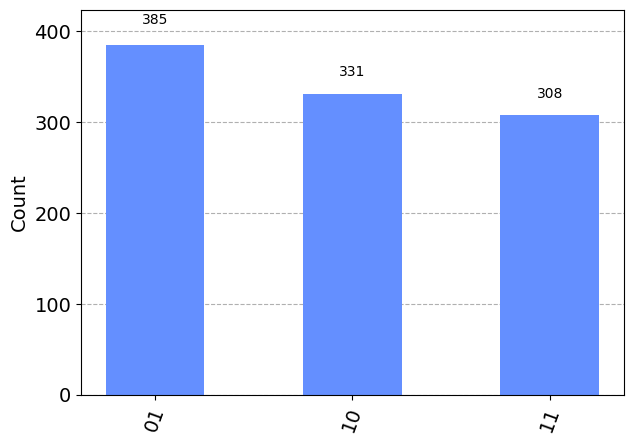

In [1]:
from qiskit import QuantumCircuit, Aer, transpile, assemble, execute
from qiskit.visualization import plot_histogram
import numpy as np

def controlled_hadamard(qc, control, target):
    # Apply H to target if control is |1>
    qc.ry(-np.pi/4, target)
    qc.cx(control, target)
    qc.ry(np.pi/4, target)

def controlled_ry(qc, control, target, digit):
    # Apply H to target if control is |1>
    qc.ry(-np.pi/2 * digit, target)
    qc.cx(control, target)
    qc.ry(np.pi/2 * digit, target)

# 创建一个有三个量子位的量子电路
qc = QuantumCircuit(3, 2)

# 对第一个量子位应用 Hadamard 门
# qc.h(1)
qc.ry(np.pi / 2 * 1.25, 1)
qc.x(2)

# 使用 CNOT 门，控制量子位是第一个量子位，目标量子位是第二个量子位
qc.cx(1, 2)

qc.cx(1, 0)

controlled_hadamard(qc, 0, 2)
qc.cx(2, 1)

# 测量所有量子位
qc.measure([1,2], [0,1])

# 绘制量子电路
print(qc.draw())

# 执行量子电路
simulator = Aer.get_backend('qasm_simulator')
compiled_circuit = transpile(qc, simulator)
qobj = assemble(compiled_circuit)
results = execute(qc, backend=simulator, shots=1024).result()
counts = results.get_counts(qc)

# 绘制直方图
plot_histogram(counts)


     ┌───┐                                     
q_0: ┤ X ├──■────────────────────────■─────────
     └───┘┌─┴─┐                 ┌────┴─────┐┌─┐
q_1: ─────┤ X ├──■───────■──────┤ Ry(π/20) ├┤M├
          └───┘┌─┴─┐┌────┴─────┐└───┬─┬────┘└╥┘
q_2: ──────────┤ X ├┤ Ry(π/20) ├────┤M├──────╫─
               └───┘└──────────┘    └╥┘      ║ 
c: 2/════════════════════════════════╩═══════╩═
                                     1       0 


/tmp/ipykernel_755846/940388544.py:39: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  results = execute(qc, backend=simulator, shots=1024).result()


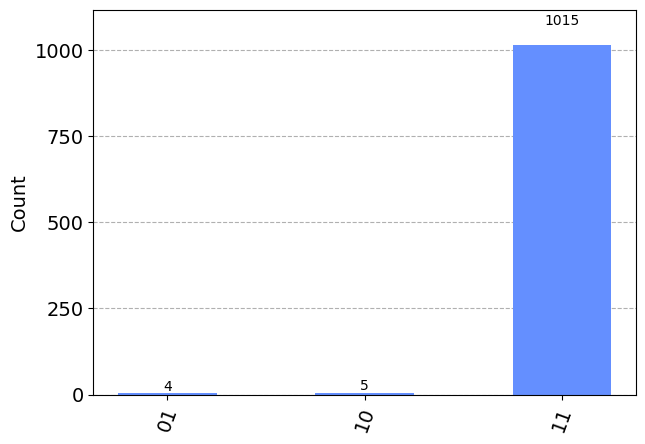

In [14]:
from qiskit import QuantumCircuit, Aer, transpile, assemble, execute
from qiskit.visualization import plot_histogram
import numpy as np

def controlled_hadamard(qc, control, target):
    # Apply H to target if control is |1>
    qc.ry(-np.pi/4, target)
    qc.cx(control, target)
    qc.ry(np.pi/4, target)

def controlled_ry(qc, control, target, digit):
    # Apply H to target if control is |1>
    qc.ry(np.pi/2 * digit, target)
    qc.cx(control, target)
    qc.ry(-np.pi/2 * digit, target)

# 创建一个有三个量子位的量子电路
qc = QuantumCircuit(3, 2)

# 对第一个量子位应用 Hadamard 门
qc.x(0)
qc.cx(0,1)
qc.cx(1,2)
qc.cry(np.pi*0.05, 1,2,)
qc.cry(np.pi*0.05, 0,1,)
# controlled_ry(qc, 1, 2, 0.05)
# controlled_ry(qc, 0, 1, 0.05)

# 测量所有量子位
qc.measure([1,2], [0,1])

# 绘制量子电路
print(qc.draw())

# 执行量子电路
simulator = Aer.get_backend('qasm_simulator')
compiled_circuit = transpile(qc, simulator)
qobj = assemble(compiled_circuit)
results = execute(qc, backend=simulator, shots=1024).result()
counts = results.get_counts(qc)

# 绘制直方图
plot_histogram(counts)


     ┌───┐                  
q_0: ┤ X ├──────────────────
     ├───┤┌──────────┐┌─┐   
q_1: ┤ X ├┤ Ry(π/20) ├┤M├───
     ├───┤├──────────┤└╥┘┌─┐
q_2: ┤ X ├┤ Ry(π/20) ├─╫─┤M├
     └───┘└──────────┘ ║ └╥┘
c: 2/══════════════════╩══╩═
                       0  1 


/tmp/ipykernel_755846/3734957549.py:39: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  results = execute(qc, backend=simulator, shots=1024).result()


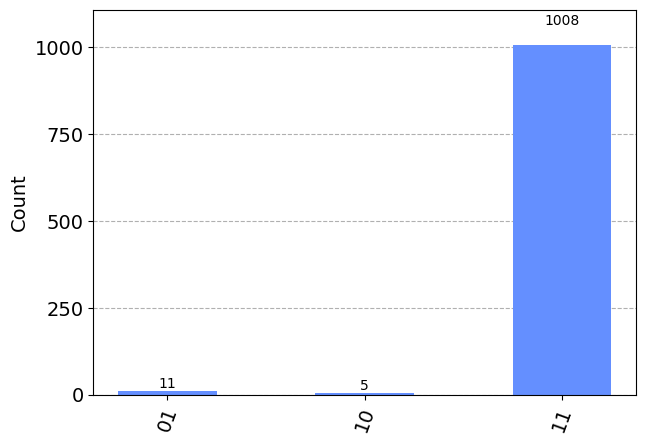

In [11]:
from qiskit import QuantumCircuit, Aer, transpile, assemble, execute
from qiskit.visualization import plot_histogram
import numpy as np

def controlled_hadamard(qc, control, target):
    # Apply H to target if control is |1>
    qc.ry(-np.pi/4, target)
    qc.cx(control, target)
    qc.ry(np.pi/4, target)

def controlled_ry(qc, control, target, digit):
    # Apply H to target if control is |1>
    qc.ry(-np.pi/2 * digit, target)
    qc.cx(control, target)
    qc.ry(np.pi/2 * digit, target)

# 创建一个有三个量子位的量子电路
qc = QuantumCircuit(3, 2)

# 对第一个量子位应用 Hadamard 门
qc.x(0)
qc.x(1)
qc.x(2)

qc.ry(np.pi*0.05, 1)
qc.ry(np.pi*0.05, 2)
# controlled_ry(qc, 0, 1, 0.05)

# 测量所有量子位
qc.measure([1,2], [0,1])

# 绘制量子电路
print(qc.draw())

# 执行量子电路
simulator = Aer.get_backend('qasm_simulator')
compiled_circuit = transpile(qc, simulator)
qobj = assemble(compiled_circuit)
results = execute(qc, backend=simulator, shots=1024).result()
counts = results.get_counts(qc)

# 绘制直方图
plot_histogram(counts)


/tmp/ipykernel_3948229/1570109299.py:52: DeprecationWarning: The 'qiskit.Aer' entry point is deprecated and will be removed in Qiskit 1.0. You should use 'qiskit_aer.Aer' directly instead.
  simulator = Aer.get_backend('qasm_simulator')
/tmp/ipykernel_3948229/1570109299.py:55: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  results = execute(qc, backend=simulator, shots=4096*4*4).result()


39


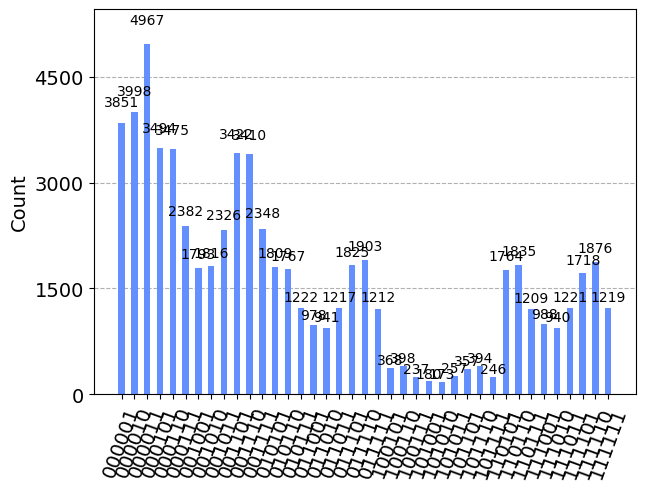

In [1]:
from qiskit import QuantumCircuit, Aer, transpile, assemble, execute
from qiskit.visualization import plot_histogram
import numpy as np
import random

def controlled_ry(qc, control, target, digit):
    # Apply H to target if control is |1>
    qc.ry(-np.pi/2 * digit, target)
    qc.cx(control, target)
    qc.ry(np.pi/2 * digit, target)

# 创建一个有三个量子位的量子电路
qc = QuantumCircuit(5+3, 4+2)

# qc.h(1)
# qc.ry(np.pi / 2 , 1)
qc.ry(np.pi / 2 * 1.25, 1)
qc.x(2)

qc.cx(1, 2)
qc.cx(1, 0)

qc.ch(0,2)
qc.cx(2, 1)

qc.ry(np.pi  * 0.5 , 3)
qc.ry(np.pi  * 0.5, 4)
# controlled_ry(qc, 4, 3, random.random())
controlled_ry(qc, 0, 3, 0.9)
qc.cx(3, 4)

qc.x(3)
qc.x(4)
qc.x(5)
qc.ccx(3,4,5)
qc.x(3)
qc.x(4)

controlled_ry(qc, 5, 6, 0.51)
# controlled_hadamard(qc, 5, 6)
controlled_ry(qc, 6, 7, 0.3)
# controlled_hadamard(qc, 5, 7)
controlled_ry(qc, 5, 7, 0.8)
# 测量所有量子位
qc.measure([1,2,3,4,6,7], [0,1,2,3,4,5])

# 绘制量子电路
# print(qc.draw())


# 执行量子电路
simulator = Aer.get_backend('qasm_simulator')
compiled_circuit = transpile(qc, simulator)
qobj = assemble(compiled_circuit)
results = execute(qc, backend=simulator, shots=4096*4*4).result()
counts = results.get_counts(qc)

print(len(counts))
# 绘制直方图
plot_histogram(counts)


/beegfs/home/lungyi45/.conda/envs/qmg/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


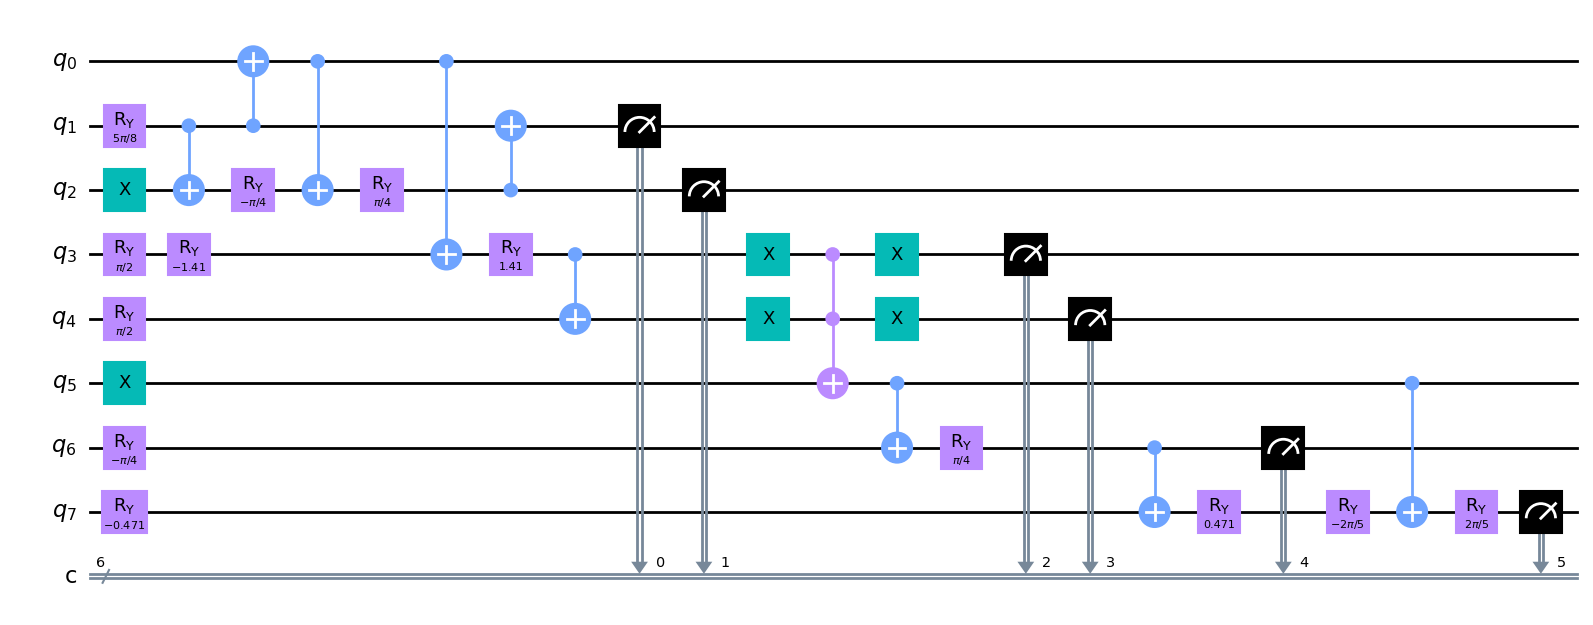

In [4]:
qc.draw(output="mpl")

In [9]:
print(qc.depth())

17


In [5]:
print(len(all_quantum_states))
print(len(set((all_quantum_states))))
print(all_quantum_states[:100])

362880
362880
['011100011001011001000000000100000000010000000010000000000000000001010001000001000000000000', '100100010101101101010000000000000000000100000100000000000000000100000000000000010000000110', '100101000110110101010000000000000100000000100000000000000001000000000000000100000100010000', '010001100101011110000001000001010000000000000000000000001001000000000001000001000000000000', '101001010001011101000000000001000000010000000001000000000001000000100000000000010000010000', '010101010110001110000000000100100000000101000000010000000101000000000000000000000000000000', '110110000101100101010000000000100000000100010000000001000100000000000000000000000001000000', '010101101110000101000101000000000000000101000001000000000000000000010000001000000000000000', '011001010111011000000000000001000000000000010000000100000000001000010000000100010000000000', '100001101101010101000000000001000000000000000000011000000000000000000100010000010000000001', '10010101100111000101000100000000000000000100

In [43]:
smiles_list = [QG.QuantumStateToSmiles(q) for q in all_quantum_states]
print(len(set(smiles_list)))

1


In [45]:
all_quantum_states[:10]

['010000001000010101000000000000010100000000000000000000000000000000000000010000000000010000',
 '000001100001010001000000000000000000000000000000000000010001000001000000000000000001000000',
 '000000100100010101000000000000000000000000000000000000000000000000010000010000000000000101',
 '010101000100000010000100010000000000000100000000000000000001000000000000000000000000000000',
 '000101010000100001000000000000000000000000000001010000010000000000000100000000000000000000',
 '000001010010010001000000000000000000000000000000000000010001000001000000000000000001000000',
 '010001100001000100000100000000000000000000000000000000000100000100000000000000000100000000',
 '000000010001010110000000000000000000000000000000000000000000000000010000000000010001010000',
 '010101000000001001010100000000000000000000000001000000000100000000000000000000000000000000',
 '000001010101000010000000000000000000000000000000000001000001010000000001000000000000000000']

In [44]:
len(QG.ConnectivityToQuantumState(node_vector, adjacency_matrix))

90

In [18]:
print(node_vector)
print(adjacency_matrix)
new_index = (1, 5, 3, 6, 4, 7, 2)
mapping_dict = {old: new for old, new in enumerate(new_index)}

new_node_vector = np.zeros(8)
new_adjacency_matrix = np.zeros((8,8))
# atom
for old, new in mapping_dict.items():
    new_node_vector[new] = node_vector[old]
# bond
for ix, row in enumerate(adjacency_matrix):
    for iy_, bond_type_idx in enumerate(row[ix+1:]):
        if not bond_type_idx:
            continue
        iy = ix + iy_ + 1
        ix_new = mapping_dict[ix]
        iy_new = mapping_dict[iy]
        new_adjacency_matrix[ix_new][iy_new] = bond_type_idx
        new_adjacency_matrix[iy_new][ix_new] = bond_type_idx
print(new_node_vector)
print(new_adjacency_matrix)

print(QG.ConnectivityToSmiles(node_vector, adjacency_matrix))
print(QG.ConnectivityToSmiles(new_node_vector, new_adjacency_matrix))
print(QG.ConnectivityToQuantumState(node_vector, adjacency_matrix))
print(QG.ConnectivityToQuantumState(new_node_vector, new_adjacency_matrix))

[1. 1. 3. 2. 3. 2. 1. 0.]
[[0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 2. 0. 0. 0. 0. 0.]
 [0. 2. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
[0. 1. 1. 3. 3. 1. 2. 2.]
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 2. 1. 0.]
 [0. 0. 1. 0. 0. 0. 1. 1.]
 [0. 1. 0. 2. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]]
CC=NON(C)O
CC=NON(C)O
010111101110010001000000000000100000000000010000000001000000010100000000
000101111101101000000000000000000000010000000100000000100100000101000000


In [12]:
node_indices = np.arange(len(node_vector))
perms = list(permutations(node_indices))
len(perms)

362880

In [5]:


# Example usage
elements = [1, 2, 3, 4, 5, 6, 7, 8]
k = 3
permutations = generate_permutations(elements, k)
print(permutations)


[(1, 2, 3), (1, 2, 4), (1, 2, 5), (1, 2, 6), (1, 2, 7), (1, 2, 8), (1, 3, 2), (1, 3, 4), (1, 3, 5), (1, 3, 6), (1, 3, 7), (1, 3, 8), (1, 4, 2), (1, 4, 3), (1, 4, 5), (1, 4, 6), (1, 4, 7), (1, 4, 8), (1, 5, 2), (1, 5, 3), (1, 5, 4), (1, 5, 6), (1, 5, 7), (1, 5, 8), (1, 6, 2), (1, 6, 3), (1, 6, 4), (1, 6, 5), (1, 6, 7), (1, 6, 8), (1, 7, 2), (1, 7, 3), (1, 7, 4), (1, 7, 5), (1, 7, 6), (1, 7, 8), (1, 8, 2), (1, 8, 3), (1, 8, 4), (1, 8, 5), (1, 8, 6), (1, 8, 7), (2, 1, 3), (2, 1, 4), (2, 1, 5), (2, 1, 6), (2, 1, 7), (2, 1, 8), (2, 3, 1), (2, 3, 4), (2, 3, 5), (2, 3, 6), (2, 3, 7), (2, 3, 8), (2, 4, 1), (2, 4, 3), (2, 4, 5), (2, 4, 6), (2, 4, 7), (2, 4, 8), (2, 5, 1), (2, 5, 3), (2, 5, 4), (2, 5, 6), (2, 5, 7), (2, 5, 8), (2, 6, 1), (2, 6, 3), (2, 6, 4), (2, 6, 5), (2, 6, 7), (2, 6, 8), (2, 7, 1), (2, 7, 3), (2, 7, 4), (2, 7, 5), (2, 7, 6), (2, 7, 8), (2, 8, 1), (2, 8, 3), (2, 8, 4), (2, 8, 5), (2, 8, 6), (2, 8, 7), (3, 1, 2), (3, 1, 4), (3, 1, 5), (3, 1, 6), (3, 1, 7), (3, 1, 8), (3, 2, 1)

In [9]:
node_vector = np.array([1, 0, 0, 0, 3.])
adjacency_matrix = np.array([[0, 0, 0, 0, 0.],
                             [0, 0, 1, 0, 0.],
                             [0, 0, 0, 0, 0.],
                             [0, 0, 0, 0, 0.],
                             [0, 0, 0, 0, 0.]])
print(ConnectivityToSmiles(node_vector, adjacency_matrix))

0 1
0 2
0 3
0 4
1 2
None


In [3]:
smiles = "CCNC=O"
mol = Chem.MolFromSmiles(smiles)
for i, atom in enumerate(mol.GetAtoms()):
    print(atom.GetIdx())
    # print(atom.GetSymbol())
    # atom.SetAtomMapNum(i)
    # print(atom.GetAtomMapNum())
    # print(atom.Get)
    # print(bond.GetBondType())
print(Chem.MolToSmiles(mol))
for i, atom in enumerate(mol.GetAtoms()):
    print(atom.GetIdx())


0
1
2
3
4
CCNC=O


In [19]:
def decimal_to_binary(x, padd_length=1):
    """
    Parameters:
    x (int): The decimal value.

    Returns:
    str: A binary bit string.
    """
    bit = "0"*padd_length + bin(x)[2:]
    return bit[-2:]

decimal_to_binary(3)

'11'